In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import ujson as json
import glob as g
import random as rnd
import os.path as op
import time
import math
import numpy as np
from skimage import io, transform
import skimage.color as skc

from tqdm import tqdm

import pandas as pd
import seaborn as sns

import multiprocessing
import hashlib as hl
import scipy.spatial.distance as sd

In [2]:
catalog = json.load(open('/media/jakob/bigdata/train/S.json', 'r'))
len(catalog['pages'])

18436

In [3]:
test_split = 0.7
# original_shape = 44,  66 , 3
tile_shape = 48,  48 , 3
SAMPLE_SIZE = 48
TILE_SIZE = 16
sample_shape = TILE_SIZE, TILE_SIZE, 3

In [4]:
def sample_img_data(catalog, k=None, rand=None, ext='.jpg'):
    if not k:
        k = len(catalog['pages'])
    if not rand:
        rand = rnd.Random(catalog['name'])
    path = catalog['path']
    sample = rand.sample(catalog['pages'],k)
    for page in sample:
        yield op.join(path, page['path'] + ext)

def preprocess(path, shape=(44, 66)):
    img = io.imread(path)
    return transform.resize(img,shape)



# pool = multiprocessing.Pool(processes=4)
# images = np.stack(pool.map(preprocess,sample_img_data(catalog,k=10000)))
# pool.close()
# pool.join()
# np.save('/media/jakob/bigdata/train/S_{}_{}'.format(*images.shape[1:-1]), images)

In [44]:

pool = multiprocessing.Pool(processes=4)
images = np.concatenate(pool.map(random_img_tiles,tqdm(sample_img_data(catalog,k=320))))
pool.close()
pool.join()
np.save('/media/jakob/bigdata/train/S_Tiles_{}_{}'.format(*images.shape), images)

## Image sampling 

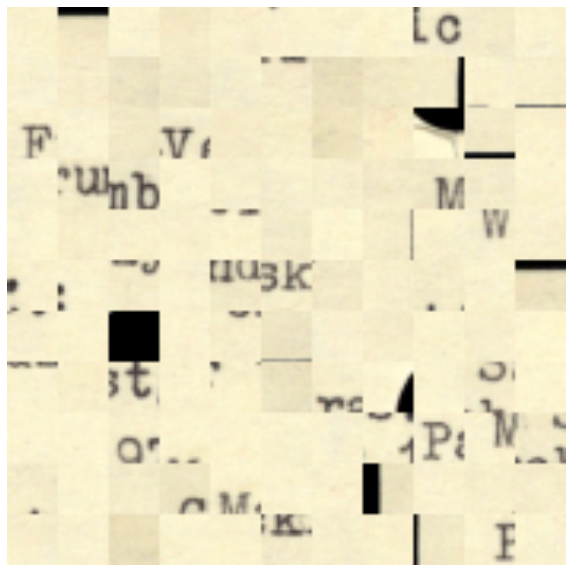

In [5]:
def img_grid(sample_selected, original_shape):
    n = int(math.floor(math.sqrt(len(sample_selected))))
    figure = np.zeros((original_shape[0] * n, original_shape[1] * n, 3),np.float32)
    for i in range(0,n):
        for j in range(0,n):
            digit = sample_selected[j * n + i].reshape(original_shape)
            figure[i * original_shape[0]: (i + 1) * original_shape[0],
                   j * original_shape[1]: (j + 1) * original_shape[1]] = digit
    return figure

def random_img_tiles(path, k=16, tile_size=TILE_SIZE, sample_size=SAMPLE_SIZE):
    tile_dim = tile_size * tile_size * 3
    img = skc.rgb2hsv(io.imread(path))
    rand_x = rnd.Random(path)
    rand_y = rnd.Random(''.join(reversed(path)))
    y_max , x_max, _ = img.shape
    tiles = np.zeros((k,tile_dim), dtype=np.float32)
    for i in range(k):        
        x_offset = rand_x.randint(0, x_max - sample_size)
        y_offset = rand_y.randint(0, y_max - sample_size)
        tile = img[y_offset:y_offset + sample_size,
                  x_offset:x_offset + sample_size]
        tile = transform.resize(tile,(tile_size, tile_size))
        tiles[i] = tile.reshape(tile_dim)
    
    return tiles

fig = plt.figure(figsize=(10, 10))

segments = random_img_tiles(list(sample_img_data(catalog,k=1))[0],k=128)
ax = plt.imshow(skc.hsv2rgb(img_grid(segments,  sample_shape)) )
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
fig.savefig('../plots/random_tiles.pdf')

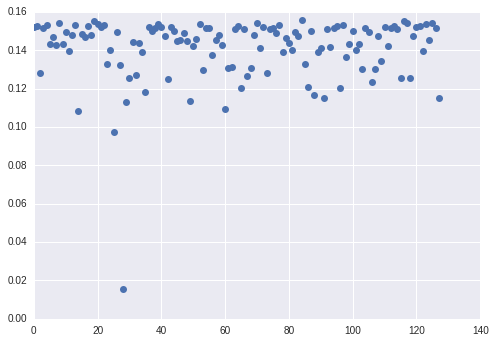

In [6]:
plt.plot(np.var(segments,1), 'o')

In [7]:
images = np.load('/media/jakob/bigdata/train/tiles/S_Tiles_5120_768.npy')
x_train = images[:int(len(images) * test_split)]
x_test  = images[int(len(images) * test_split):]
print(x_train.shape, x_train.dtype, len(x_test))
images = 0

((3584, 768), dtype('float32'), 1536)


In [16]:
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

## VAE-Test
see https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py

In [8]:

from keras.layers import Input, Dense, Lambda, Reshape, Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

batch_size = 32
original_dim = x_train.shape[1]
latent_dim = 2
intermediate_dim = 128
epsilon_std = 0.01
nb_epoch = 40

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_std = Dense(latent_dim)(h)

print original_dim

768


In [13]:
def sampling(args):
    z_mean, z_log_std = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_std) * epsilon

def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_std - K.square(z_mean) - K.exp(z_log_std), axis=-1)
    return xent_loss + kl_loss


In [14]:
# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_std])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_std])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.n_epochs= 0 

In [15]:
test = Model(x, z)
test.compile(optimizer='rmsprop', loss=vae_loss)
test.output_shape
vae.output_shape

((32, 2), 768)

In [26]:
loss = history.history['loss']

In [61]:
n_epochs = 40
history = vae.fit(x_train, x_train,
        verbose=0,
#         callbacks=[hera_model.callback],
        shuffle=False,
        nb_epoch=n_epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))
vae.n_epochs = vae.n_epochs + n_epochs
loss = np.concatenate([loss, history.history['loss']],0)

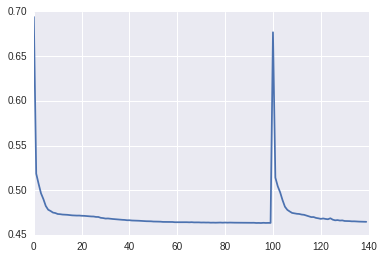

In [62]:
plt.plot(loss)

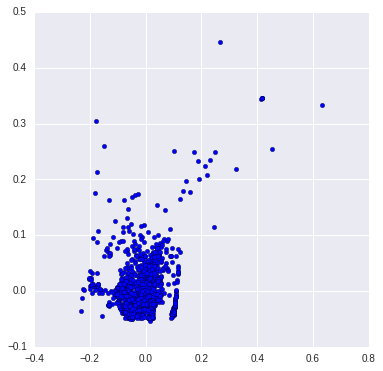

In [28]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
# plt.colorbar()
plt.show()

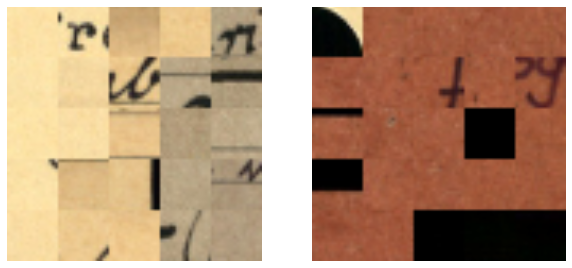

In [29]:
border = 0.07
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(121)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
sample_selected = x_test[x_test_encoded[:,0] < border][::2]         
plt.imshow(skc.hsv2rgb(img_grid(sample_selected[:32], sample_shape)))
ax = plt.subplot(122)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
sample_selected = x_test[x_test_encoded[:,0] > border][::2]         
plt.imshow(skc.hsv2rgb(img_grid(sample_selected[:32], sample_shape)))

fig.savefig('../plots/vae_tile_groups.pdf')

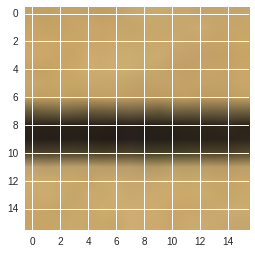

In [30]:
plt.imshow(skc.hsv2rgb(x_test[727].reshape(sample_shape)))

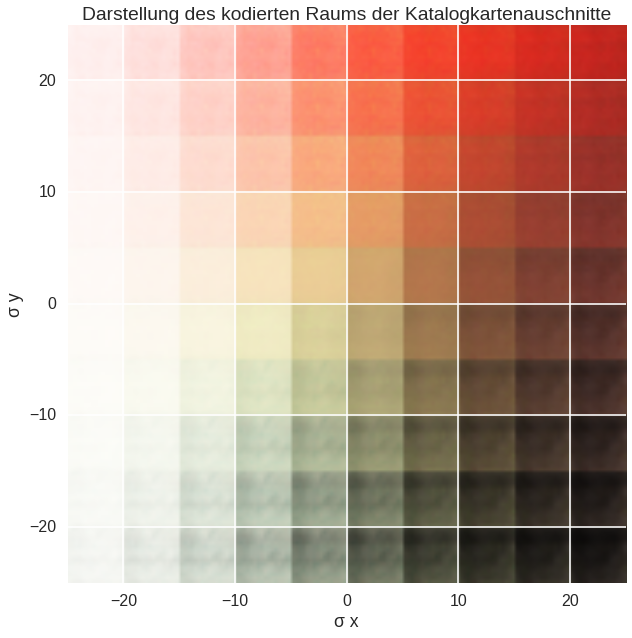

In [65]:
sns.set_context('poster')
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

n = 10  # figure with 15x15 digits
digit_size = 28 
figure = np.zeros((sample_shape[0] * n, sample_shape[1] * n, 3))
space = 25
grid_x = np.linspace(-space, space, n)
grid_y = np.linspace(-space, space, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = skc.hsv2rgb(x_decoded[0].reshape(sample_shape))
        figure[i * sample_shape[0]: (i + 1) * sample_shape[0],
               j * sample_shape[1]: (j + 1) * sample_shape[1]] = digit

        
fig = plt.figure(figsize=(10, 10))
plt.imshow(figure,extent=[-space,space,-space, space])
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
# plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
# plt.scatter(card_cat_pred[:, 0], card_cat_pred[:, 1], color='r')
plt.title('Darstellung des kodierten Raums der Katalogkartenauschnitte')
plt.xlabel(u'σ x')
plt.ylabel(u'σ y')
fig.savefig('../plots/vae_{}.jpg'.format(vae.n_epochs), dpi=300)

In [32]:
img_paths = list(sample_img_data(catalog,k=20))
images = map(random_img_tiles,img_paths)

In [33]:
thumbs = list(map(preprocess, img_paths))

In [87]:
avg_pred = lambda tiles: sd.euclidean(np.mean(encoder.predict(tiles),0),card_cat_mean)
pred = np.stack(map(avg_pred, images),0)

In [88]:
pred

array([ 0.22103587,  0.3379726 ,  0.10219363,  0.10012434,  0.1030471 ,
        0.06604912,  0.18123818,  0.11158064,  0.08749171,  0.13135343,
        0.11964073,  0.10670184,  0.0869098 ,  0.00647994,  0.24606986,
        0.01155616,  0.1091045 ,  0.15509466,  0.14284063,  0.23555195])

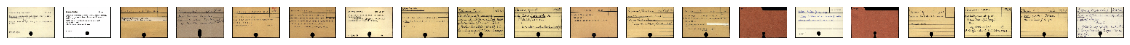

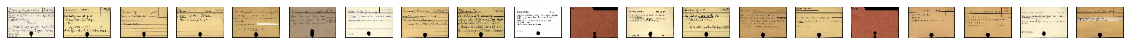

In [111]:
sort = [thumb for val, thumb in sorted(zip(pred, thumbs))]

def img_rows(rows):
    n = 0
    for i_r, row in enumerate(rows):
        plt.figure(figsize=(20, 2))
        for i in range(len(row)):
            n = n + 1
            ax = plt.subplot(i_r + 1, len(row), n)
            plt.imshow(row[i])
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

img_rows([thumbs, sort])
# sort = [thumb for val, thumb in sorted(zip(pred[:,0], thumbs))]
# n = len(thumbs)
# plt.figure(figsize=(20, 2))
# for i in range(n):
#     ax = plt.subplot(2, n, n + i + 1)
#     plt.imshow(thumbs[i])
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

In [16]:
vae_dir = '/media/jakob/bigdata/models/vae_card_samples/'
vae_name =  'vae1_card_samples'

In [34]:
def save_model(model, model_dir, name):
    with open(op.join(model_dir, name + '.json'), 'w') as model_json_file:
        model_json_file.write(model.to_json())
    vae.save_weights(op.join(model_dir, name + '.h5'))

save_model(vae, vae_dir , vae_name + '_{}'.format(vae.n_epochs))


In [17]:
vae.load_weights(op.join(vae_dir,vae_name + '_100.h5'))

In [18]:
card_cat = pd.read_csv('/media/jakob/bigdata/card_catogeries/seperators.csv',header=None, names=['name', 'category'])
card_cat_paths = map(lambda name: op.join(catalog['path'],name), card_cat[(card_cat.category == 'sep')]['name'] + '.jpg')
card_cat_paths

[u'/media/jakob/bigdata/train/S/S002/00000238.jpg',
 u'/media/jakob/bigdata/train/S/S002/00000731.jpg',
 u'/media/jakob/bigdata/train/S/S091/00000001.jpg',
 u'/media/jakob/bigdata/train/S/S143/00000001.jpg',
 u'/media/jakob/bigdata/train/S/S161/00000001.jpg']

In [19]:
card_labels = pd.read_csv('/media/jakob/bigdata/train/S_labels.csv')
card_labels['path'] = map(lambda name: op.join(op.dirname(catalog['path']),name), card_labels['path'])
card_labels.head()

,label,path
0,cursiv,/media/jakob/bigdata/train/S/S001/00000001.jpg
1,druck,/media/jakob/bigdata/train/S/S001/00000051.jpg
2,cursiv,/media/jakob/bigdata/train/S/S001/00000101.jpg
3,seperator,/media/jakob/bigdata/train/S/S001/00000116.jpg
4,cursiv,/media/jakob/bigdata/train/S/S001/00000151.jpg


In [20]:
card_labels.groupby('label').size()

label
cursiv          537
cursiv/druck     50
druck           276
seperator       138
dtype: int64

In [21]:
images = map(random_img_tiles, tqdm(card_labels['path']))


100%|██████████| 1001/1001 [06:32<00:00,  2.46it/s]


NameError: name 'encoder' is not defined

In [23]:
card_cat_pred = np.array([np.mean(encoder.predict(sample),0) for sample in images])

In [24]:
card_labels['encoding_x'] = card_cat_pred[:,0]
card_labels['encoding_y'] = card_cat_pred[:,1]

In [25]:
card_cat_mean = np.array(card_cat_pred).mean(0)

In [26]:
encoder = Model(x, z_mean)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

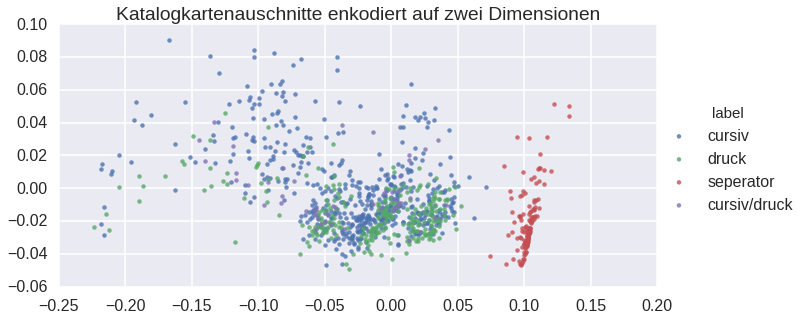

In [56]:
sns.set_context("poster")

fig = plt.figure(figsize=(6, 6))
g = sns.lmplot('encoding_x','encoding_y',data=card_labels, hue='label', fit_reg=False, aspect=2)
g.set_titles(template='Test{col_var}', row_template='row', col_template='col')
g.set_xlabels(label="")
g.set_ylabels(label="")
plt.title("Katalogkartenauschnitte enkodiert auf zwei Dimensionen")
plt.show()
g.savefig('../plots/vae_categories.pdf', dpi=600)
g.savefig('../plots/vae_categories_poster.jpg', dpi=600)

# fig.set_title('sdd')

In [57]:
x_test_encoded
code_dist = lambda tiles: sd.euclidean(tiles,card_cat_mean)
pred = np.stack(map(code_dist, x_test_encoded),0)

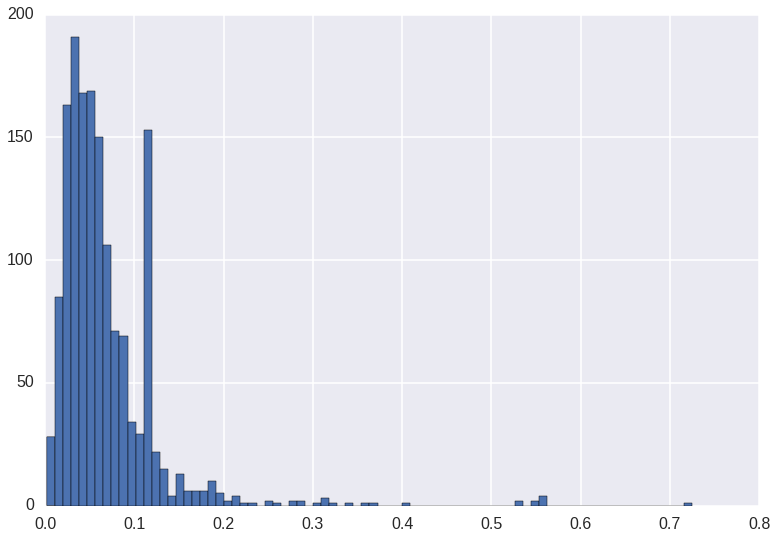

In [58]:
plt.hist(pred,bins=80)
plt.show()